# Spectral and temporal modifications

### Arnaud Capitan

#### Lab session recap

___

The goal of this lab session is to implement the PSOLA method for the analysis and/or the synthesis of speech signals.
___

In [221]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf

import scipy

## Functions

In [222]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs
    x = x - np.mean(x)
    N = len(x)
    
    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in the same directory as the notebook.

In [223]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [224]:
x, Fs= sf.read(file_path)
print(f"Fs = {Fs}, len(x) = {len(x)}")

Fs = 11025, len(x) = 59964


In [225]:
IPython.display.Audio(file_path)

In [226]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

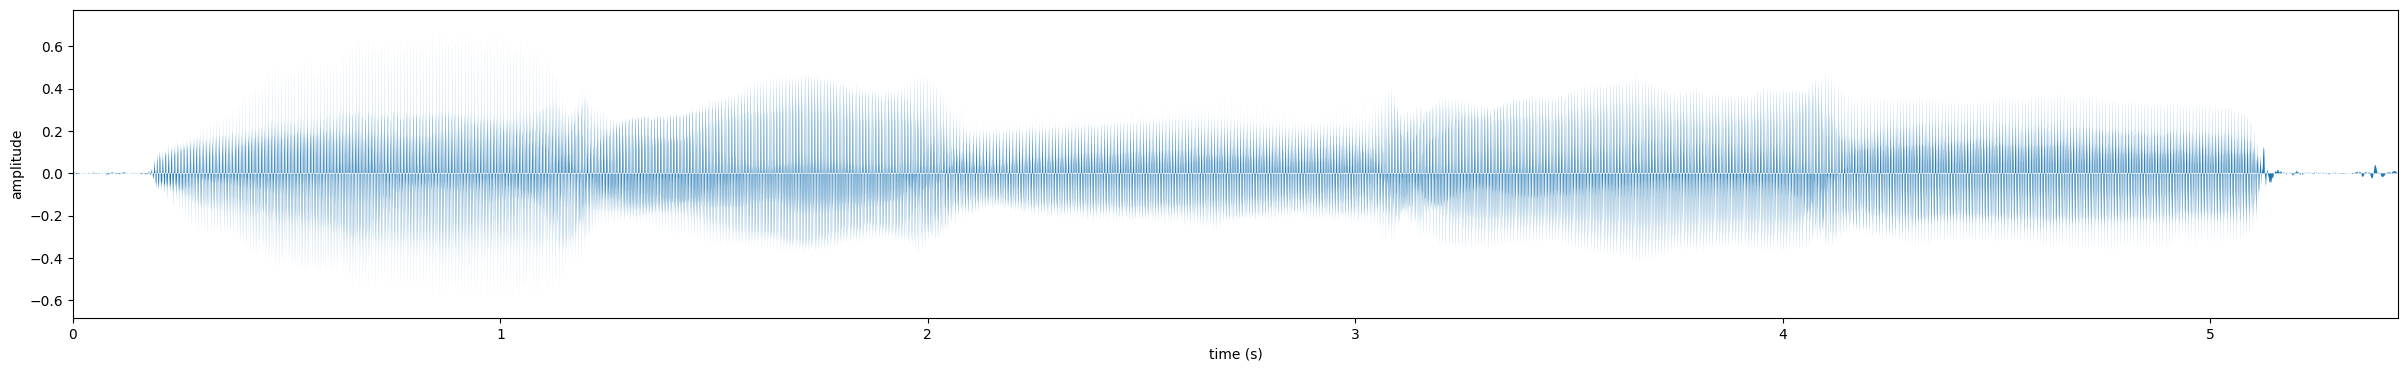

In [227]:
plot_sound(x, times)

In [228]:
#sf.write('new_aeiou.wav',x, samplerate=Fs) # To write a new wave file

___

## 1. Extraction of the analysis marks

A will be formed of three rows, such that :

 - $A(0,n) = t_a(n)$ is the time corresponding to the $n^{\text{th}}$ analysis mark ($t_a(n) \in \textbf{N}$ is expressed in number of samples) 
 - $A(1,n)$ = voiced($n$) is a Boolean which indicates whether the signal is voiced or unvoiced in the neighborhood of this mark
 - $A(2,n) = P_a(n) \in \textbf{N}$ describes the pitch corresponding to the same mark (i.e. the  period expressed in number of samples) in the voiced case, or equals 10ms Fs in the unvoiced case.

In [229]:
def AnalysisPitchMarks(s,Fs):
    ta = 0 # ta(0) = 0 for initialization
    Pa = 0.01*Fs # Pa(0) = 10ms x Fs for initialization
    A_0 = [ta]
    A_1 = [False]
    A_2 = [Pa]
    while (ta+Pa)<len(s):
        Pa = int(np.floor(2.5*Pa))
        x = s[ta:ta+Pa]
        Pa,voiced= period(x,Fs)
        ta += int(Pa)
        A_0.append(ta)
        A_1.append(voiced)
        A_2.append(Pa)
    A = [A_0,A_1,A_2]
    return(np.asarray(A))
        

We have $A_0$ corresponding to the time indices of our pitch marks in signal $s$, $A_1$ the voiced (True) / unvoiced (False) pitch marks, and $A_2$ is the period in number of samples for voiced case, or 10ms x Fs in the unvoiced case.

## 2. Synthesis and modification of the temporal and spectral scales

In [230]:
A = AnalysisPitchMarks(x,Fs)
B_default = np.asarray((A[0,:],[i+1 for i in range(len(A[0,:]))]))

print(A)
print(B_default)

[[0.0000e+00 1.1000e+02 2.2000e+02 ... 5.9690e+04 5.9800e+04 5.9937e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.1025e+02 1.1000e+02 1.1000e+02 ... 1.1000e+02 1.1000e+02 1.3700e+02]]
[[0.0000e+00 1.1000e+02 2.2000e+02 ... 5.9690e+04 5.9800e+04 5.9937e+04]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 7.0600e+02 7.0700e+02 7.0800e+02]]


### 2.1. Signal synthesis

For this function, since it is performed recursively on $k \geq 1$, we need to know the value of $k_{\text{end}}$

Since the recursion is done over the synthesis marks / the index of the analysis marks, we have $k_{\text{end}} = \text{len(nk)}$ with $nk$ being the array of the indices of the analysis mark corresponding to the synthesis mark, nk = B[1,:]

#### Important :

We assume that the recursion $k \geq 1$ describes the indices, thus we can shift everything by 1, and starting at 0 to work with arrays here.

For the recursion :
 - Extraction of a sequence x centered at $t_a(n(k))$ and of length $2P_a(n(k)) + 1$

We will take as start_index for our sequence x : $t_a(n(k)) - P_a(n(k))$, and end index : $t_a(n(k)) + P_a(n(k))$, thus having a length of :

$t_a(n(k)) + P_a(n(k)) - (t_a(n(k)) - P_a(n(k))) + 1 = 2 P_a(n(k)) + 1$

We do the same for the overlap-add part.

In [231]:
def Synthesis(s,Fs,A,B=B_default):
    ta = A[0,:].astype(int) #Analysis marks
    Pa = A[2,:].astype(int) #Periods
    ts = B[0,:].astype(int) #Synthesis marks
    nk = B[1,:].astype(int) #Index of analysis marks
    k_end = len(nk)-1
    if nk[k_end] == len(Pa) : #Default case
        y = np.zeros(int(ts[k_end]+Pa[-1]))
    else:
        y = np.zeros(int(ts[k_end]+Pa[nk[k_end]]))
    for k in range(k_end):
        center = ta[nk[k]]
        start_index = center - Pa[nk[k]]
        end_index = center + Pa[nk[k]]
        if not (start_index < 0 or end_index >= len(s)): #Otherwise we cannot extract a sequence x of lenght 2Pa(n(k))+1
            x = s[start_index:end_index+1]
            w = scipy.signal.windows.hann(2*Pa[nk[k]]+1)
            x = x*w
            if not (ts[k]-Pa[nk[k]] < 0 or ts[k]+Pa[nk[k]] >= len(y)): #Otherwise we cannot overlapp-add
                y[ts[k]-Pa[nk[k]]:ts[k]+Pa[nk[k]]+1] += x
    print(f"Length of synthesized signal : {len(y)} ; k_end = {k_end}")
    return y

Length of synthesized signal : 60074 ; k_end = 707


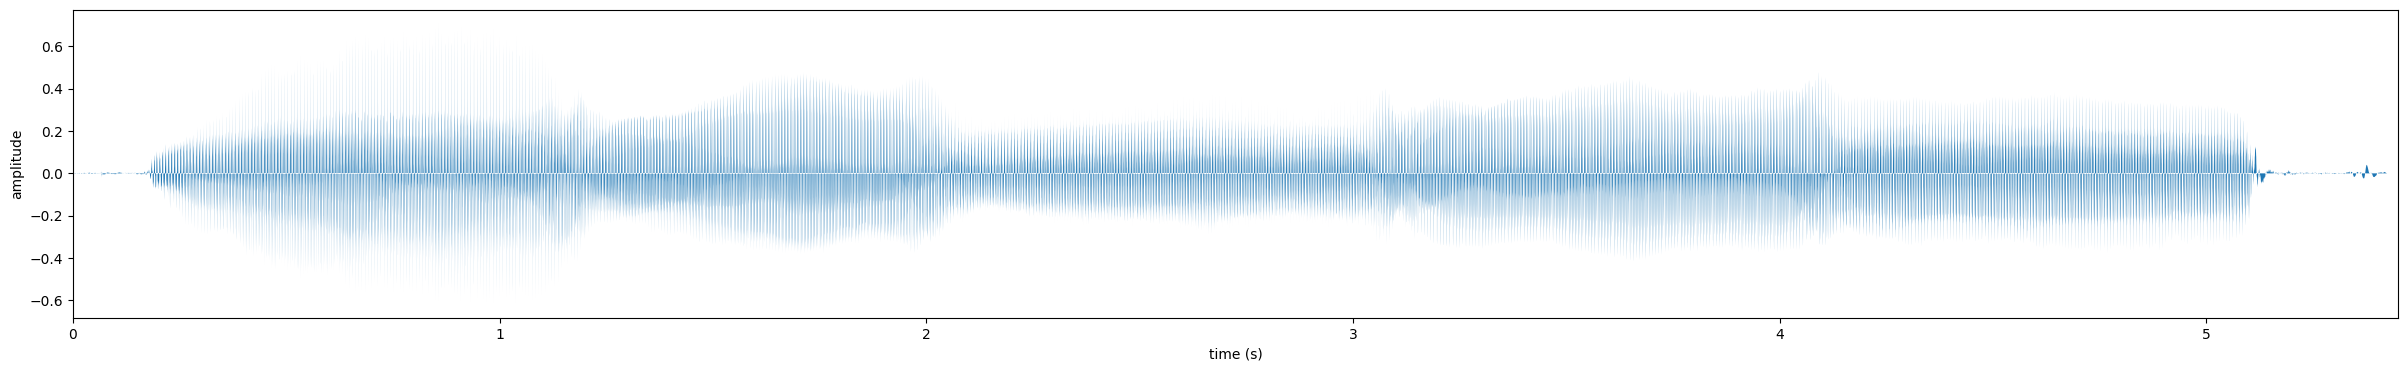

In [232]:
synth_default = Synthesis(x,Fs,A,B=B_default)
times_default= np.arange(len(synth_default))*timestep
plot_sound(synth_default, times_default)
sf.write('synth_default_aeiou.wav', synth_default, samplerate = Fs)
IPython.display.Audio('synth_default_aeiou.wav')

We correctly get a synthesis by default without modification.

### 2.2. Modification of the temporal scale

We now want to determine the synthesis marks that will modify the temporal scale by a factor $\alpha$, i.e. to determine a matrix $B$ such that the  duration of the signal synthesized by function Synthesis is equal to that of the original signal s multiplied by $\alpha$.

___

We will proceed by recursion on $k \geq 1$, by using a non-integer index n(k):

 - $t_s(k) = t_s(k-1) + P_a(\left\lfloor n(k) \right\rfloor)$
 - $n(k+1) = n(k) + \dfrac{1}{\alpha}$

 The algorithm will be initialized by setting $t_s(0) = 1$ and $n(1) = 1$. 
 
 We will only stock integer values in matrix B.

 Here, $k_{\text{end}} = \text{len(A[2,:])}$ since we work on the periods

In [233]:
def ChangeTimeScale(alpha,A,Fs):
    Pa = A[2,:]
    ts = 1
    n = 1
    B_0 = [ts]
    B_1 = [n]
    n += 1/alpha #First iteration outside of loop, see explanation below
    while int(np.floor(n)) < len(Pa):
        ts += Pa[int(np.floor(n))]
        B_0.append(ts)
        B_1.append(n)
        n += 1/alpha
    B_0 = np.asarray(B_0).astype(int)
    B_1 = np.asarray(B_1).astype(int)
    B = np.asarray([B_0,B_1])
    return(B)

We put the first iteration before the while loop so that the incrementation on n doesn't go beyond $\text{len}(P_a)$ when computing the values iteratively of $t_s$ inside the loop using $n(k)$.

Also, since we need $n(k)$ to compute $t_s(k)$, we need to increment it by $\dfrac{1}{\alpha}$ once before entering the loop.

Length of synthesized signal : 30034 ; k_end = 353


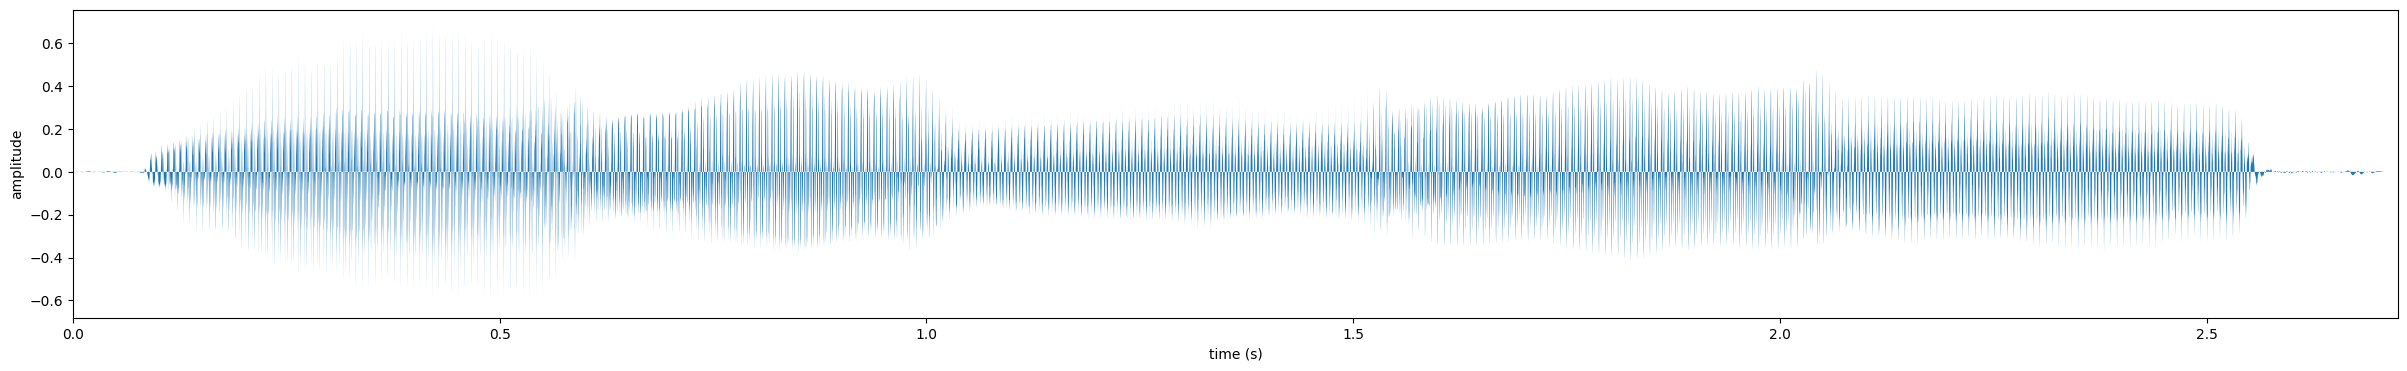

In [234]:
synth_speed_up = Synthesis(x,Fs,A,B=ChangeTimeScale(1/2,A,Fs))
times_speed_up= np.arange(len(synth_speed_up))*timestep
plot_sound(synth_speed_up, times_speed_up)
sf.write('synth_speed_up_aeiou.wav', synth_speed_up, samplerate = Fs)
IPython.display.Audio('synth_speed_up_aeiou.wav')

When using $\alpha = \dfrac{1}{2}$, we correclty get a speed-up version of our signal. We can do the same for a slowed-down version with $\alpha = 2$.

Length of synthesized signal : 119902 ; k_end = 1413


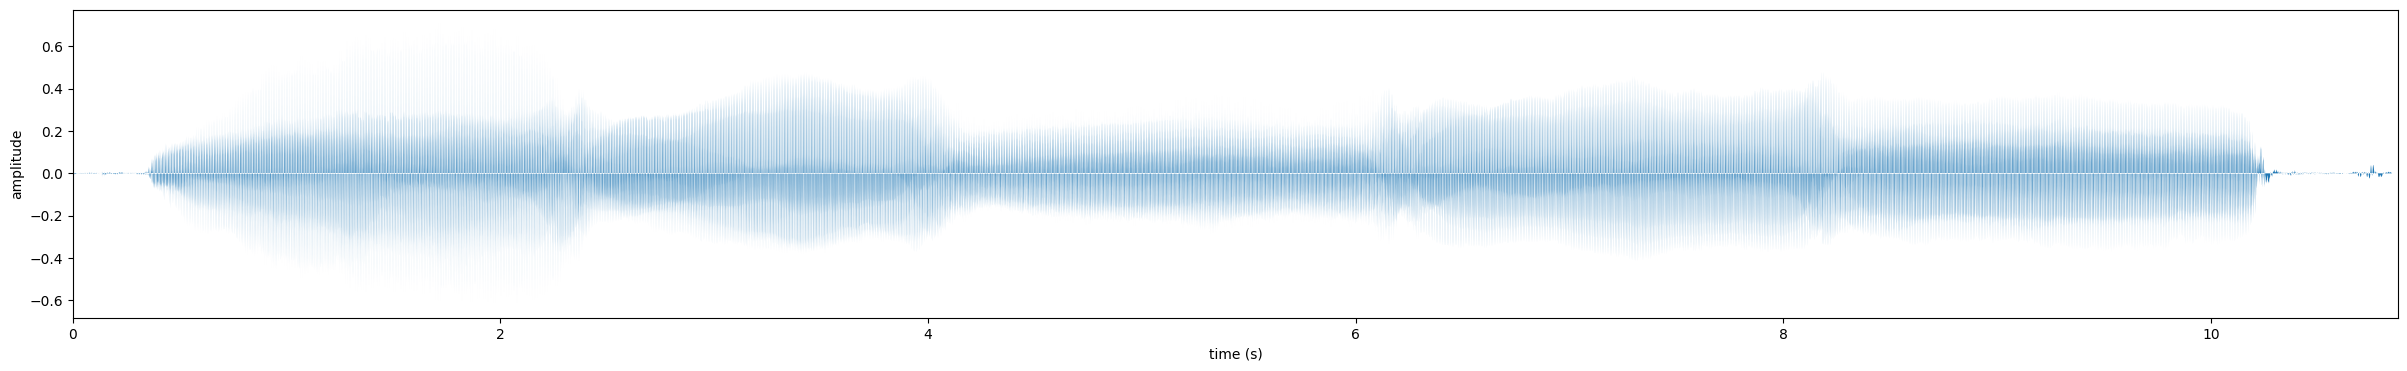

In [235]:
synth_slowed = Synthesis(x,Fs,A,B=ChangeTimeScale(2,A,Fs))
times_slowed= np.arange(len(synth_slowed))*timestep
plot_sound(synth_slowed, times_slowed)
sf.write('synth_slowed_aeiou.wav', synth_slowed, samplerate = Fs)
IPython.display.Audio('synth_slowed_aeiou.wav')

### 2.3. Modification of the temporal scale

We will now perform the dual operation of the previous one: determine the synthesis marks that will modify the spectral scale by a factor $\beta$, i.e. determine a matrix B such that the fundamental frequency of  the signal synthesized by function Synthesis is equal to that of the original signal s multiplied by $\beta$.

___

As in the previous case, we will proceed by recursion on $k \geq 1$, by using a non-integer index $n(k)$ and non-integer synthesis times $t_s(k)$, and by making the difference between the voiced and unvoiced cases:
 
 - If the analysis mark of index $\left\lfloor n(k) \right\rfloor$ is voiced, $\text{scale}(k) = \dfrac{1}{\beta}$, otherwise $\text{scale}(k) = 1$
 - $t_s(k) = t_s(k-1) + \text{scale}(k) P_a(\left\lfloor n(k) \right\rfloor)$
 - $n(k+1) = n(k) +\text{scale}(k)$
 
We will only stock integer values in matrix B.

In [236]:
def ChangePitchScale(beta,A,Fs):
    Voiced = A[1,:]
    Pa = A[2,:]
    ts = 1
    n = 1
    B_0 = [ts]
    B_1 = [n]
    if Voiced[int(np.floor(n))] == 1: #If it is voiced, computation of scale(1) to begin the iterative computation
        scale = 1/beta
    else :
        scale = 1
    n += scale #Computation of n(2)
    while int(np.floor(n)) < len(Pa):
        if Voiced[int(np.floor(n))] == 1:
            scale = 1/beta
        else :
            scale = 1
        ts += Pa[int(np.floor(n))]*scale
        B_0.append(ts)
        B_1.append(n)
        n += scale
    B_0 = np.asarray(B_0).astype(int)
    B_1 = np.asarray(B_1).astype(int)
    B = np.asarray([B_0,B_1])
    return(B)

Length of synthesized signal : 59965 ; k_end = 1365


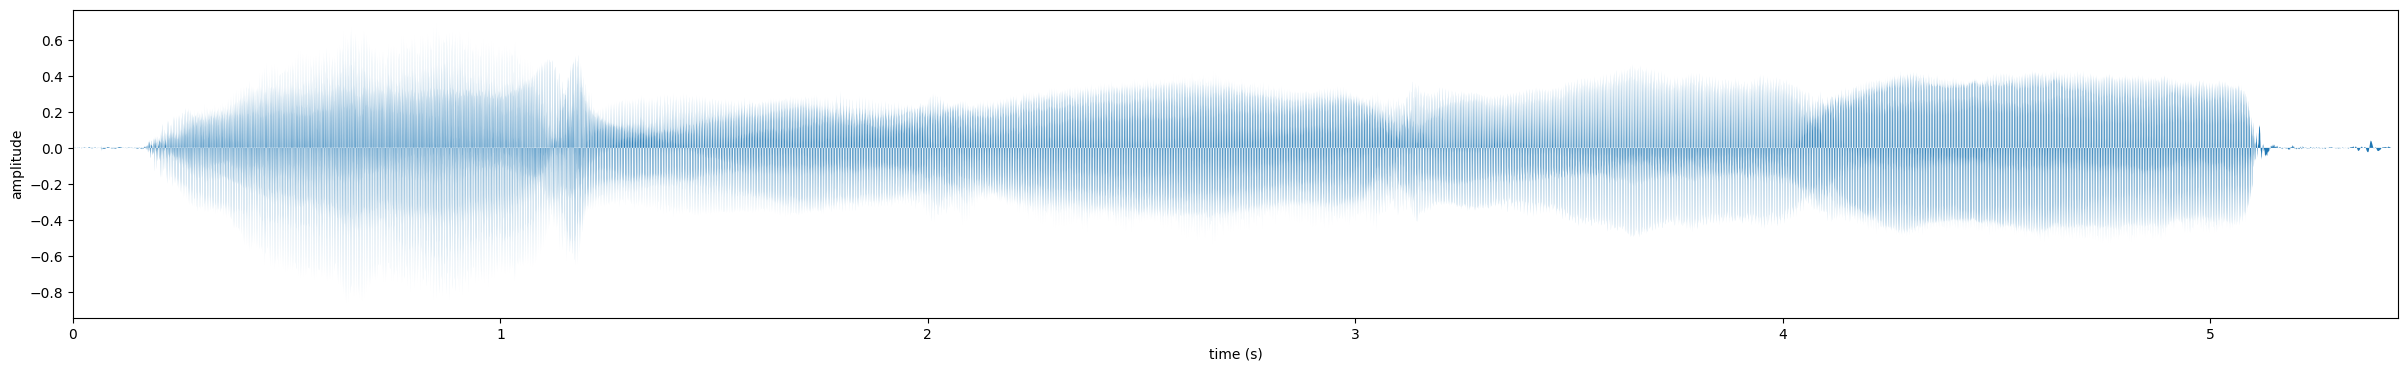

In [237]:
synth_pitch_up = Synthesis(x,Fs,A,B=ChangePitchScale(2,A,Fs))
times_pitch_up = np.arange(len(synth_pitch_up))*timestep
plot_sound(synth_pitch_up, times_pitch_up)
sf.write('synth_pitch_up_aeiou.wav', synth_pitch_up, samplerate = Fs)
IPython.display.Audio('synth_pitch_up_aeiou.wav')

Length of synthesized signal : 59902 ; k_end = 375


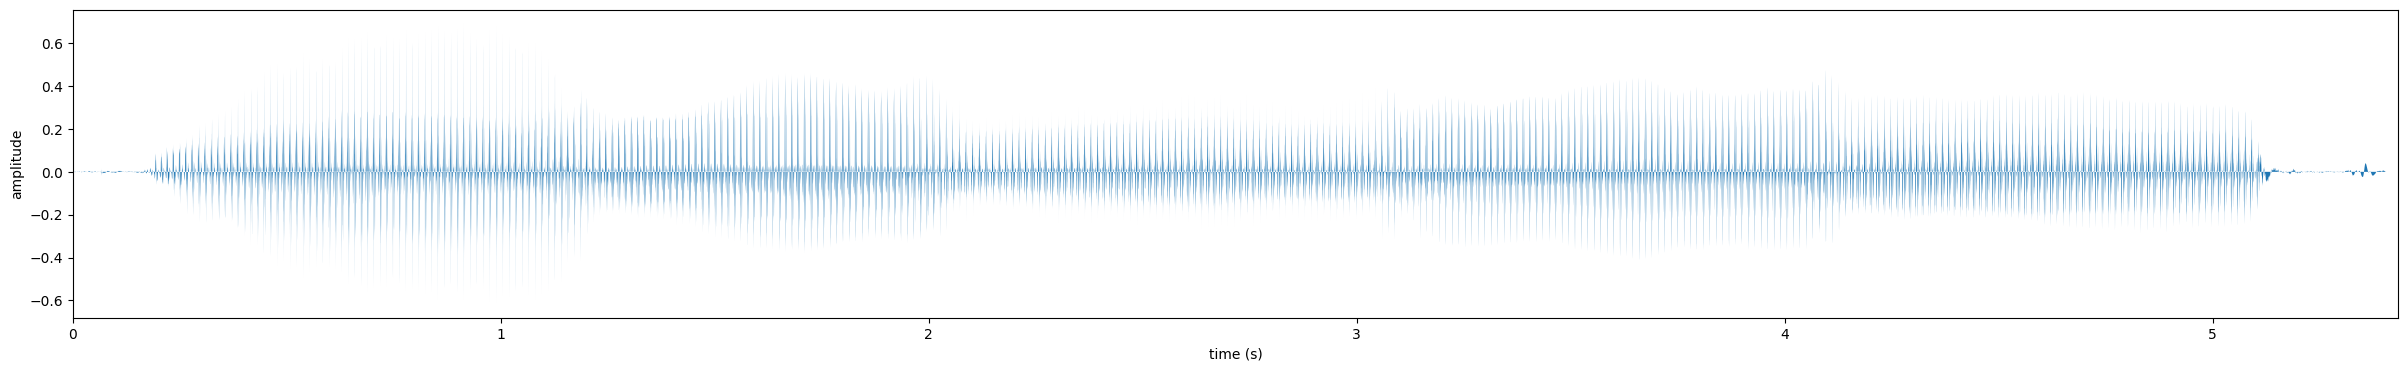

In [238]:
synth_pitch_down = Synthesis(x,Fs,A,B=ChangePitchScale(1/2,A,Fs))
times_pitch_down = np.arange(len(synth_pitch_down))*timestep
plot_sound(synth_pitch_down, times_pitch_down)
sf.write('synth_pitch_down_aeiou.wav', synth_pitch_down, samplerate = Fs)
IPython.display.Audio('synth_pitch_down_aeiou.wav')

When using $\beta = \dfrac{1}{2}$, we correclty get a pitched-down version of our signal, and with $\beta = 2$ we get a pitched-up version.

### 2.4. Joint modification of the temporal and spectral scales

In [239]:
def ChangeBothScale(alpha,beta,A,Fs):
    Voiced = A[1,:]
    Pa = A[2,:]
    ts = 1
    n = 1
    B_0 = [ts]
    B_1 = [n]
    if Voiced[int(np.floor(n))] == 1:
        scale = 1/beta
    else :
        scale = 1
    n += scale/alpha
    while int(np.floor(n)) < len(Pa):
        if Voiced[int(np.floor(n))] == 1:
            scale = 1/beta
        else :
            scale = 1
        ts += Pa[int(np.floor(n))]*scale
        B_0.append(ts)
        B_1.append(n)
        n += scale/alpha
    B_0 = np.asarray(B_0).astype(int)
    B_1 = np.asarray(B_1).astype(int)
    B = np.asarray([B_0,B_1])
    return(B)

Length of synthesized signal : 30074 ; k_end = 187


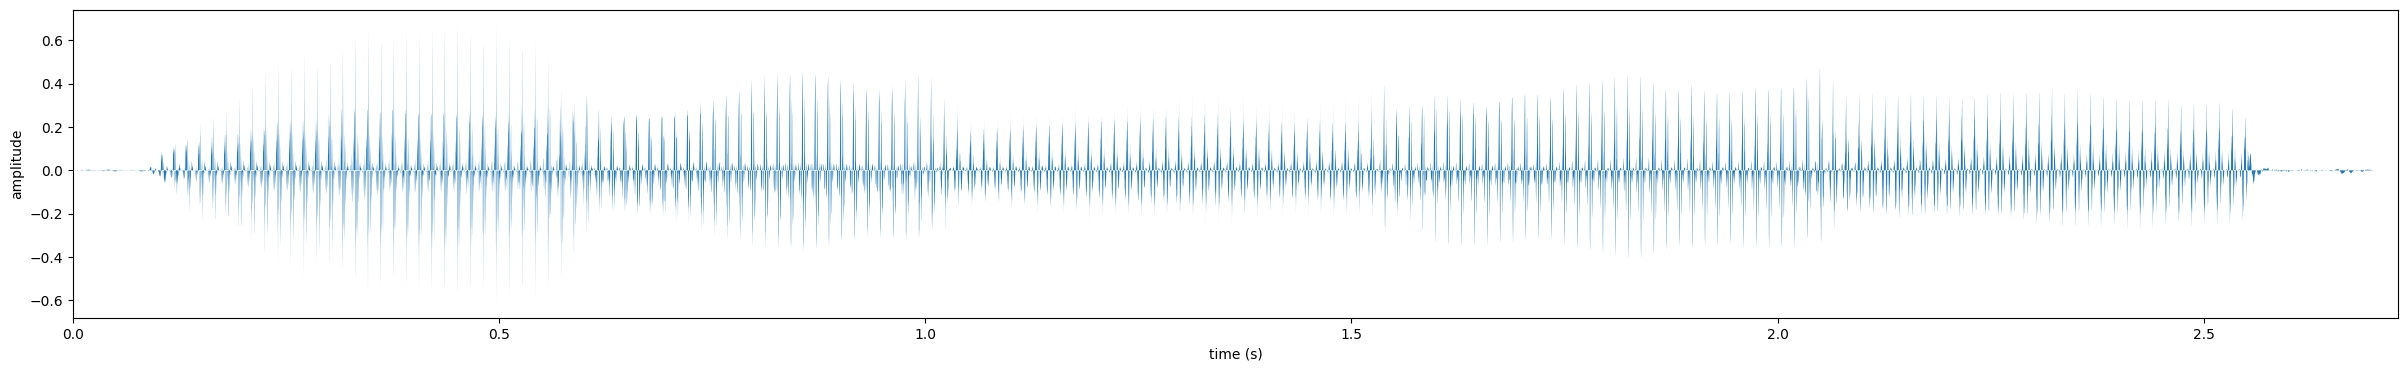

In [240]:
synth_speed_up_pitched_down = Synthesis(x,Fs,A,B=ChangeBothScale(alpha=1/2,beta=1/2,A=A,Fs=Fs))
times_speed_up_pitched_down = np.arange(len(synth_speed_up_pitched_down))*timestep
plot_sound(synth_speed_up_pitched_down, times_speed_up_pitched_down)
sf.write('synth_speed_up_pitched_down_aeiou.wav', synth_speed_up_pitched_down, samplerate = Fs)
IPython.display.Audio('synth_speed_up_pitched_down_aeiou.wav')

Length of synthesized signal : 119902 ; k_end = 2731


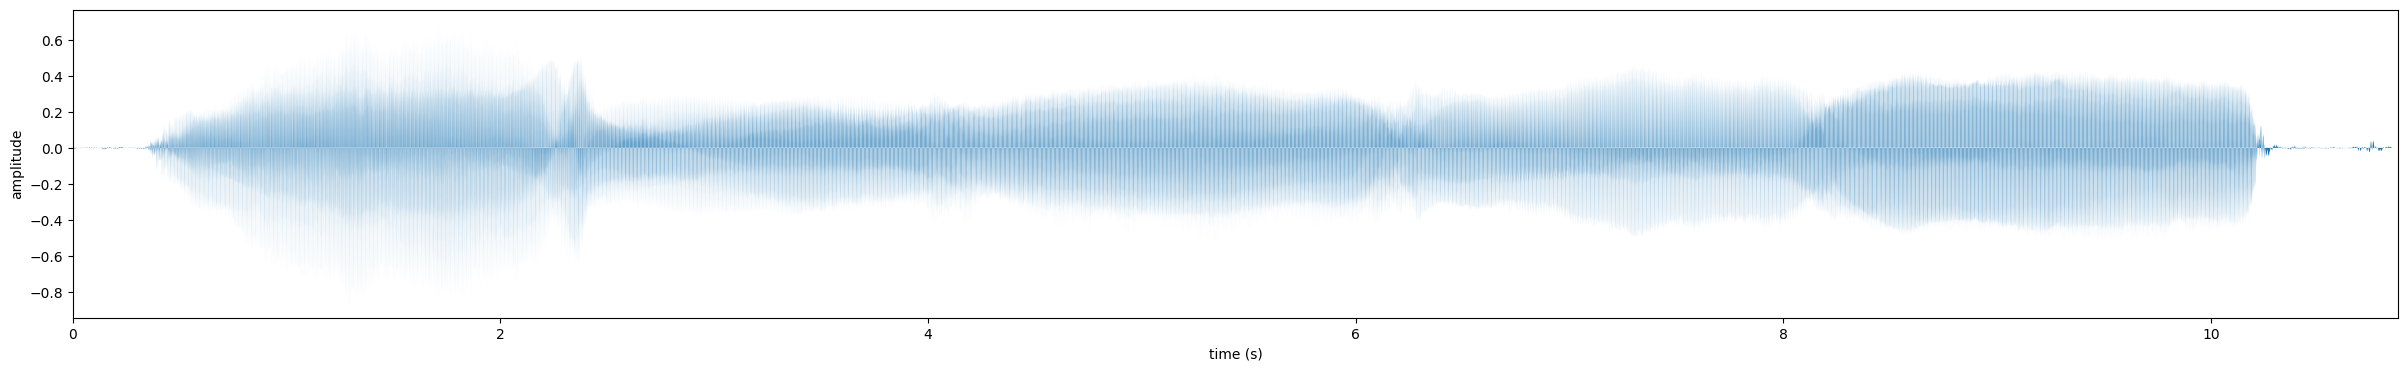

In [241]:
synth_slowed_down_pitched_up = Synthesis(x,Fs,A,B=ChangeBothScale(alpha=2,beta=2,A=A,Fs=Fs))
times_slowed_down_pitched_up = np.arange(len(synth_slowed_down_pitched_up))*timestep
plot_sound(synth_slowed_down_pitched_up, times_slowed_down_pitched_up)
sf.write('synth_slowed_down_pitched_up_aeiou.wav', synth_slowed_down_pitched_up, samplerate = Fs)
IPython.display.Audio('synth_slowed_down_pitched_up_aeiou.wav')

We obtain the correct modifications for aeiou.wav
We try the same for an_in_on.wav :

In [242]:
filename = 'an_in_on.wav'
file_path = os.path.join(os.getcwd(), filename) 
x, Fs = sf.read(file_path)
timestep = 1/float(Fs)
IPython.display.Audio(file_path)

In [243]:
A = AnalysisPitchMarks(x,Fs)
an_in_on_slowed_down_pitched_up = Synthesis(x,Fs,A,B=ChangeBothScale(alpha=2,beta=2,A=A,Fs=Fs))
times_slowed_down_pitched_up = np.arange(len(an_in_on_slowed_down_pitched_up))*timestep
sf.write('an_in_on_slowed_down_pitched_up.wav', an_in_on_slowed_down_pitched_up, samplerate = Fs)
IPython.display.Audio('an_in_on_slowed_down_pitched_up.wav')

Length of synthesized signal : 56431 ; k_end = 809


Everything works as expected.